#### Kaggle competition

- Label satellite image chips with atmospheric conditions and land use.
- Each chip will have one unique atmospheric label and zero or multiple land use labels
- 17 Unique labels, 4 weather labels and 13 land use labels

#### What the data looks like ?
Please check EDA.ipynb for data analysis part <br>
<img style="float:left; width:600px; display: block;margin-right: 350px" src="img/eg1.jpg" />

#### Challenge
- Labels are highly imbalanced with a few labelling errors
- A lot of image chips are blurry

#### Environment
```terminal
source activate tensorflow_p36
```

#### Kaggle Evaluation - F2 SCORE
F2 is used to evaluate how good the model is and has a formula given below. F2 is similar to F1, but puts more weight on recall

$F_{2} = (1+β^{2})\frac{pr}{β^{2}p+r}$


,where *p* is precision, *r* is recall and β=2 
<br>



shortcuts (this is a quick start for me for me, ignore )
```terminal
cd ~/Desktop/metis_proj
source activate tensorflow_p36
jupyter notebook
```

In [1]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,fbeta_score,coverage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import math, glob, os, random
import operator, pickle
import cv2

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Read in labels and convert text labels to count vectors
- df_labels shape = (40479, 17)
- total train size 40479 with 17 unique label tags

In [2]:
"""GLOBAL VARIABLE"""
kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
# kaggle_path = '/Users/mumuxi/.kaggle/competitions/planet-understanding-the-amazon-from-space/'

def get_multitags(plot=False):
    texts = pd.read_csv(kaggle_path+'train_v2.csv').tags.tolist()
    tokenizer = Tokenizer(filters = '"(),./:~')
    tokenizer.fit_on_texts(texts)
    M  = tokenizer.texts_to_matrix(texts, mode='count')
    df = pd.DataFrame(data=M,columns=['0']+list(tokenizer.word_index.keys()))
    cols = df.columns.tolist()
    df = df[cols[-1:] + cols[1:-1]]
    df = df.where(df <= 1, 1) #some photos cultivation appreared twice
    if plot:
        corr = df.corr()
        fig=plt.figure(figsize=(10, 8))
        sns.heatmap(corr)
    return df


def plot_confusion_matrix(y_test,y_pred,x_labels):
    M = confusion_matrix(y_test,y_pred)
    M = M/M.sum(axis=1)[:,None]
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(M, annot=True,fmt='.0%',cmap="YlGnBu")
    ax.set_xticklabels(x_labels,rotation=30)
    ax.set_yticklabels(x_labels,rotation=30)
    plt.show()
    

df_label = get_multitags()

In [3]:
df_label.head(3)

,conventional_mine,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1. Predict weather labels (Multiclass classification)
- Weather labels are exclusive
- Predict clear,haze,partly_cloudy,cloudy tags
- Define weather_tags = \['clear','haze','partly_cloudy','cloudy'\]


All training dataset contains 1 weather label, except train_img2448.jpg has none

#### 1.1 old opencv statistical approach
- Calculate haziness, atomospheric light, image contrast of the images using openCV
- multi-class logistic 
- random forest
- gradient boosted random forest

#### 1.2 modern neutral network approach
- CNN
- Pre-trained VGG16

In [8]:
class Statistical_Approach():
    """ Predict weather labels 
        Input: image contrast, haziness and atomospheric light {max intensity at the darkest channel} """
    def __init__(self):
        self.maxdepth = 3
        self.random_num = 5678
        self.tags = ['clear','haze','partly_cloudy','cloudy']
        self.no_features = len(self.tags)
        
   
    def __load_data__(self):
        df_w = pd.DataFrame(data = pickle.load(open("haze_train.pkl", "rb")),
                            columns = ['id','w','A'])
        y = categorical_to_array(df_label[self.tags].copy(),self.no_features)
        return train_test_split(df_w[['w','A']],y,
                                 stratify=y,
                                 test_size=0.3,
                                 random_state=self.random_num)
    
    def multi_class_logistic(self,x_train,x_test,y_train,y_test):
        print ('multi class logistic')    
        lgr = LogisticRegression(multi_class="multinomial",
                                 solver='newton-cg')
        lgr.fit(x_train, y_train)
        y_pred = lgr.predict(x_test)
        plot_confusion_matrix(y_test,y_pred,x_labels=self.tags)
    
    def random_forest(self,x_train,x_test,y_train,y_test):
        print ('basic random forest')     
        rf = RandomForestClassifier(max_depth=self.maxdepth)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        plot_confusion_matrix(y_test,y_pred,x_labels=self.tags)
    
    def gbm_tree(self,x_train,x_test,y_train,y_test):
        x_train, x_val, y_train, y_val = train_test_split(
                                                          x_train, y_train, 
                                                          stratify=y_train,
                                                          test_size=0.3, 
                                                          random_state=self.random_num)
        gbm = xgb.XGBRegressor( 
                               n_estimators=3000, #arbitrary large number
                               max_depth=self.maxdepth,
                               objective="multi:softprob",
                               learning_rate=.1, 
                               subsample=1,
                               min_child_weight=1,
                               colsample_bytree=.5,  
                               num_class=self.no_features
                              )

        eval_set=[(x_train,y_train),(x_val,y_val)] #tracking train/validation error as we go
        gbm.fit( 
                x_train, y_train, 
                eval_set=eval_set,
                eval_metric='mlogloss',
                early_stopping_rounds=50,
                verbose=True #gives output log as below
        )
        y_pred = gbm.predict(x_test, ntree_limit=gbm.best_ntree_limit).argmax(axis=1)
        plot_confusion_matrix(y_test,y_pred,x_labels=self.tags)

        
    def run_models(self):
        x_train,x_test,y_train,y_test = self.__load_data__()
        self.multi_class_logistic(x_train,x_test,y_train,y_test)
        self.random_forest(x_train,x_test,y_train,y_test)
        self.gbm_tree(x_train,x_test,y_train,y_test)


multi class logistic


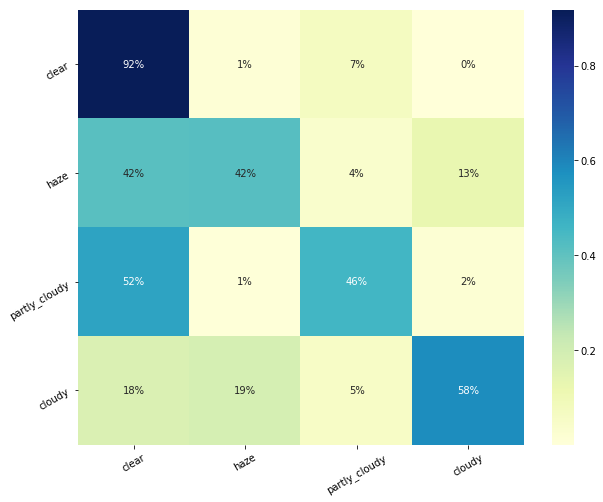

basic random forest


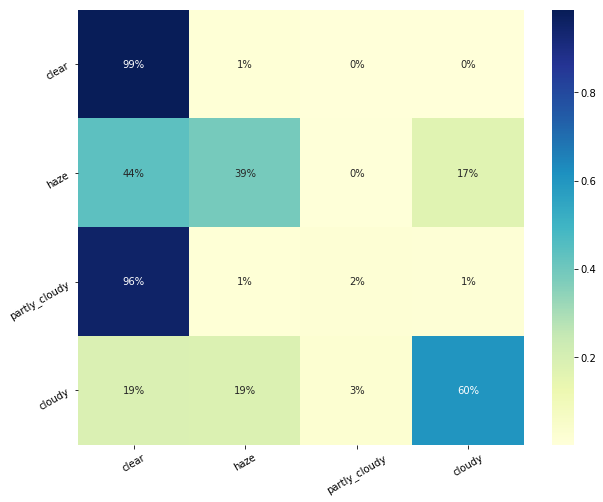

[0]	validation_0-mlogloss:1.29301	validation_1-mlogloss:1.29337
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.21561	validation_1-mlogloss:1.21627
[2]	validation_0-mlogloss:1.14683	validation_1-mlogloss:1.14715
[3]	validation_0-mlogloss:1.09102	validation_1-mlogloss:1.09105
[4]	validation_0-mlogloss:1.03858	validation_1-mlogloss:1.03857
[5]	validation_0-mlogloss:0.997669	validation_1-mlogloss:0.997934
[6]	validation_0-mlogloss:0.960643	validation_1-mlogloss:0.960871
[7]	validation_0-mlogloss:0.916801	validation_1-mlogloss:0.916401
[8]	validation_0-mlogloss:0.884701	validation_1-mlogloss:0.883923
[9]	validation_0-mlogloss:0.859046	validation_1-mlogloss:0.858236
[10]	validation_0-mlogloss:0.83638	validation_1-mlogloss:0.835522
[11]	validation_0-mlogloss:0.810215	validation_1-mlogloss:0.809202
[12]	validation_0-mlogloss:0.786686	validation_1-m

[121]	validation_0-mlogloss:0.475713	validation_1-mlogloss:0.477097
[122]	validation_0-mlogloss:0.475504	validation_1-mlogloss:0.476971
[123]	validation_0-mlogloss:0.475287	validation_1-mlogloss:0.476898
[124]	validation_0-mlogloss:0.475174	validation_1-mlogloss:0.476811
[125]	validation_0-mlogloss:0.47498	validation_1-mlogloss:0.476639
[126]	validation_0-mlogloss:0.47478	validation_1-mlogloss:0.476484
[127]	validation_0-mlogloss:0.474597	validation_1-mlogloss:0.476418
[128]	validation_0-mlogloss:0.474377	validation_1-mlogloss:0.476293
[129]	validation_0-mlogloss:0.474256	validation_1-mlogloss:0.47621
[130]	validation_0-mlogloss:0.474117	validation_1-mlogloss:0.476124
[131]	validation_0-mlogloss:0.473965	validation_1-mlogloss:0.476021
[132]	validation_0-mlogloss:0.47374	validation_1-mlogloss:0.475928
[133]	validation_0-mlogloss:0.473586	validation_1-mlogloss:0.475842
[134]	validation_0-mlogloss:0.473435	validation_1-mlogloss:0.475766
[135]	validation_0-mlogloss:0.473242	validation_1-ml

[242]	validation_0-mlogloss:0.463921	validation_1-mlogloss:0.473803
[243]	validation_0-mlogloss:0.463846	validation_1-mlogloss:0.473826
[244]	validation_0-mlogloss:0.463746	validation_1-mlogloss:0.473817
[245]	validation_0-mlogloss:0.463712	validation_1-mlogloss:0.473804
[246]	validation_0-mlogloss:0.463654	validation_1-mlogloss:0.473846
[247]	validation_0-mlogloss:0.463584	validation_1-mlogloss:0.473841
[248]	validation_0-mlogloss:0.463538	validation_1-mlogloss:0.473855
[249]	validation_0-mlogloss:0.463473	validation_1-mlogloss:0.473879
[250]	validation_0-mlogloss:0.46343	validation_1-mlogloss:0.473879
[251]	validation_0-mlogloss:0.46335	validation_1-mlogloss:0.473847
[252]	validation_0-mlogloss:0.463293	validation_1-mlogloss:0.473841
[253]	validation_0-mlogloss:0.463229	validation_1-mlogloss:0.473841
[254]	validation_0-mlogloss:0.463172	validation_1-mlogloss:0.473829
[255]	validation_0-mlogloss:0.463117	validation_1-mlogloss:0.473871
[256]	validation_0-mlogloss:0.463049	validation_1-

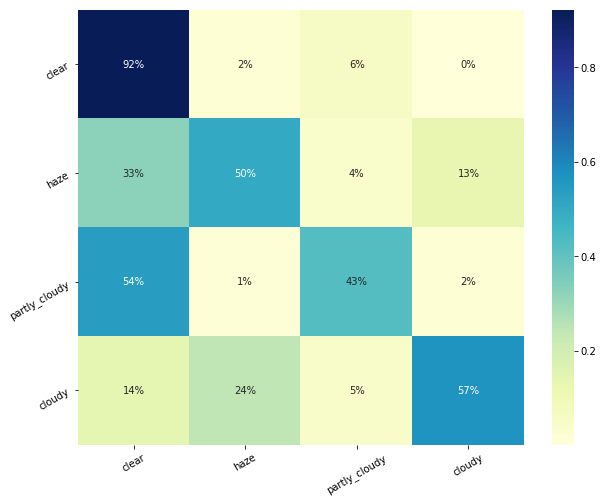

In [9]:
ss_predictor = Statistical_Approach()
ss_predictor.run_models()

####  1.2 Neural Network model

Initialise model as a sequential network. There are two basic ways of initialising a neural network, either by a sequence of layers or as a graph

####  Load data
- opencv convert image to numpy array (256x256x3) 256 pixels 3 RBG channels
- train/test split

####  Model Work Flow
1. **Conv2D** 
    - Images => 2 D arrays
    - Videos => Convolution 3-D 
    
    
2. **MaxPooling2D**:<br> The primary aim of a pooling operation is to reduce the size of the images. Different types of pooling operations like Min Pooling, Mean Pooling, etc. Here in MaxPooling we need the maximum value pixel from the respective region of interest.


3. **Flatten**:<br> Flattening is the process of converting all the resultant 2 dimensional arrays into a continuous vector.


4. **Dense** 
    - units: no nodes in the hidden layer
5. **Compile**
    - Optimizer:  stochastic gradient descent algorithm
    - Loss: loss function
    - Metrics: performance metric
    
    
6. Activation function
    - weather:  choose **softmax** for **multi-class problem**
        -  weather labels are exclusive (Image chips only have 1 weather labels ) 
    - land_use: choose **sigmoid** for **multi-label problem**
        -  The probability given by softmax is not independent from the other class probabilies. We want class probabilities to be independent. 
        - With the sigmoid activation function at the output layer the probability of a class c_j as bernoulli distribution.

    $P(c_j|x_i) = \frac{1}{1 + \exp(-z_j)}$
    
7. Image_nets
- __build_layers Basic CNN
- __build_layers2 Dense_net

    

In [3]:
from keras.models import Model,Sequential
from keras.layers import Input,InputLayer, Flatten, ZeroPadding2D, Conv2D,concatenate
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
import keras.backend as K
import keras
from keras.applications.vgg16 import VGG16
from a02_custom_metrics import precision,recall,F2_score
from a10_densenet_121 import DenseNet

In [ ]:
weather  = ['clear','partly_cloudy','cloudy','haze']
land_use = ['primary', 'agriculture', 'road', 'water','cultivation', 'habitation','bare_ground', 
            'conventional_mine', 'selective_logging', 'artisinal_mine', 'blooming','slash_burn', 'blow_down']
#       if u wanna use Keras img_generator instead of __data_transformation(). however img_gen was much slower 
#       model.fit_generator(datagen.flow(X_train, y_train, batch_size=self.batch_size),
#                           steps_per_epoch=len(X_train)/self.batch_size, epochs=self.epochs)
# datagen = keras.preprocessing.image.ImageDataGenerator(
#         featurewise_center=False,
#         samplewise_center=False,
#         featurewise_std_normalization=False,
#         samplewise_std_normalization=False,
#         zca_whitening=False,
#         rotation_range=90,
#         zoom_range=0.,
#         channel_shift_range=0.,
#         fill_mode='nearest',
#         cval=0.,
#         horizontal_flip=True,
#         vertical_flip=True,
#         rescale=None)  

class Neural_nets(keras.utils.Sequence):
    global eps
    eps = 1.1e-5
    def __init__(self,haze_free,optimizer, loss, class_weight,epochs,batch_size,weight_path = None):
        self.haze_free = haze_free
        self.optimizer = optimizer
        self.class_weight = class_weight
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_path = weight_path
    
    def __data_transformation(self,X_):
        N = len(X_)
        for flip_id in random.sample(range(N), N//10):
            X_[flip_id] = X_[flip_id][::-1, :, :]    
        for rotate_id in random.sample(range(N), N//10):
            X_[flip_id] = np.rot90(X_[flip_id], k=random.randint(0, 3))
        return X_
  
    def __data_generation(self):
        '''Generates data'''   
        path =  '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
        path += 'train_clean/' if self.haze_free else 'train-jpg/'
        read = lambda i: cv2.imread(path+f'train_{i}.jpg')
        y_train, y_test = train_test_split(df_label[weather + land_use], test_size=0.3,random_state=1100)
        X_train = self.__data_transformation(np.array(list(map(read,y_train.index.tolist()))))
        X_test = self.__data_transformation(np.array(list(map(read,y_test.index.tolist()))))
        y_train = [y_train[weather],y_train[land_use]]
        y_test  = [y_test[weather],y_test[land_use]]
        return X_train,y_train,X_test,y_test
    
    def __conv_block(self,x):
        x = BatchNormalization(epsilon=eps, axis=3)(x)
        x = Conv2D(32, (3, 3), activation = 'relu',padding='same', use_bias=False)(x)
        return x
    
    def __pooling_block(self,x):
        x = BatchNormalization(epsilon=eps, axis=3)(x)
        x = Conv2D(32, (3, 3), activation = 'relu',padding='same',use_bias=False)(x)
        x = AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x
    
    def __dense_block(self,x):
        """ Build a dense_block where the output of each conv_block is fed to subsequent ones
            x: input tensor """
        concat_feat = x
        for i in range(3):
            x = self.__conv_block(concat_feat)
            concat_feat = concatenate([concat_feat, x], axis=3)
        return concat_feat
        
    def __build_layers(self):
        input_tensor = Input(shape=(256,256,3))
        x = self.__conv_block(input_tensor)
        x = ZeroPadding2D((1, 1))(x)
        x = MaxPooling2D((3, 3), strides=(2,2))(x)
        x = self.__conv_block(x)
        x = self.__pooling_block(x)
        x = self.__conv_block(x)
        x = self.__pooling_block(x) 
        
        x = BatchNormalization(epsilon=eps, axis=3)(x)
        x = Activation('relu')(x)
        x = GlobalAveragePooling2D()(x)

        lb1 = Dense(4, activation='softmax', name='weather')(x)
        lb2 = Dense(13, activation='sigmoid', name='land')(x)
        model = Model(input_tensor, [lb1,lb2], name='cnn_net')
        return model
    
    def __build_layers2(self):
        """DenseNet 121"""
        return DenseNet(nb_dense_block=3, growth_rate=32, nb_filter=32, reduction=0.0, dropout_rate=0.2)

    def __build_model(self):
        model = self.__build_layers2()
        model.compile(optimizer = self.optimizer, 
                      loss = self.loss, 
                      metrics = [F2_score])
        return model
    
    
    def train_model(self):
        model = self.__build_model()
        X_train,y_train,X_test,y_test = self.__data_generation()
        return (X_train,y_train,X_test,y_test,'')
        print ('data done')
        cb_1 = keras.callbacks.EarlyStopping(monitor='loss', patience=PATIENCE, verbose=0)
        model.fit(X_train, y_train, batch_size=self.batch_size, 
                  epochs=self.epochs,
                  callbacks=[cb_1],
                  class_weight = self.class_weight,
                  validation_data=(X_test, y_test)

                  )
        return (X_train,y_train,X_test,y_test,model)
    
    
    def train_model_with_data(self,X_train,y_train):
        model = self.__build_model()
        cb_1 = keras.callbacks.EarlyStopping(monitor='loss', patience=PATIENCE, verbose=0)
        model.fit(X_train, y_train, batch_size=self.batch_size, 
                  epochs=self.epochs,   
                  callbacks=[cb_1],
                  class_weight = self.class_weight,
                  validation_data=(X_test, y_test)
                 )
        return model
    
PATIENCE = 50    
params = {'haze_free':True,
          'optimizer':'adam',
          'loss': ['categorical_crossentropy','binary_crossentropy'],
          'class_weight': {0: 1.,
                           1: 4.,
                           2: 10.,
                           3: 10.,
                           4: 1.,
                           5: 3.,
                           6: 5.,
                           7: 5.,
                           8: 10.,
                           9: 10.,
                           10: 50,
                           11: 300,
                           12: 100,
                           13: 100,
                           14: 100,
                           15: 200,
                           16: 300},
          'epochs': 15,
          'batch_size': 32
         }

c = Neural_nets(**params)
# X_train,y_train,X_test,y_test, cnn = c.train_model()
cnn = c.train_model_with_data(X_train,y_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 262, 262, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 262, 262, 3)  12          conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 32) 4704        conv1_bn[0][0]                   
__________________________________________________________________________________________________
conv1_scal

Train on 28335 samples, validate on 12144 samples
Epoch 1/15
28335/28335 [==============================] - 725s 26ms/step - loss: 0.5802 - weather_loss: 0.4047 - land_loss: 0.1755 - weather_F2_score: nan - land_F2_score: 0.6517 - val_loss: 0.7181 - val_weather_loss: 0.5349 - val_land_loss: 0.1832 - val_weather_F2_score: 0.8174 - val_land_F2_score: 0.6522
Epoch 2/15
28335/28335 [==============================] - 707s 25ms/step - loss: 0.4683 - weather_loss: 0.3094 - land_loss: 0.1589 - weather_F2_score: 0.8796 - land_F2_score: 0.6911 - val_loss: 0.6029 - val_weather_loss: 0.4375 - val_land_loss: 0.1654 - val_weather_F2_score: 0.8355 - val_land_F2_score: 0.6517
Epoch 3/15
28335/28335 [==============================] - 707s 25ms/step - loss: 0.4420 - weather_loss: 0.2885 - land_loss: 0.1535 - weather_F2_score: 0.8880 - land_F2_score: 0.7063 - val_loss: 0.4349 - val_weather_loss: 0.2686 - val_land_loss: 0.1663 - val_weather_F2_score: 0.9010 - val_land_F2_score: 0.6528
Epoch 4/15
 5344/283

In [12]:
y_pred_train = cnn.predict(X_train)
y_pred_test  = cnn.predict(X_test)

In [13]:
# """ save model """
cnn.save('b01_dense121.h5')
# cnn.save('b00_cnn.h5')

#### 1.3 Evaluation 
- show confusion matrix for every label
- calculate f2 score
- tuning threshold 
- tho using sigmoid, you do not need 

In [16]:
""" Weather labels"""

def evaluation(y_pred,y_true):
    """weather"""
    y_pred[0] = (y_pred[0] > 0.5)*1
    for n in range(4):
        print (round(fbeta_score(y_true[0].iloc[:,n], y_pred[0][:,n], average='binary', beta=2),3))
    print ('*'*20)
    y_pred[1] = (y_pred[1] > 0.5)*1
    for n in range(13):
        print (round(fbeta_score(y_true[1].iloc[:,n], y_pred[1][:,n], average='binary', beta=2),3))
print ('F2 score ')        
evaluation(y_pred_test,y_test)        

0.966
0.852
0.809
0.651
********************
0.984
0.819
0.685
0.622
0.292
0.428
0.0
0.075
0.067
0.501
0.0
0.0
0.0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
def multilabel_confusion_matrix(y_pred,y_true):
    y_pred = (y_pred > 0.5)*1
    for n in range(13):
        M = confusion_matrix(y_true.iloc[:,n], y_pred[:,n])
        sns.heatmap(M, annot=True,fmt='d',cmap="YlGnBu")
        plt.show()
multilabel_confusion_matrix(y_pred_test[1],y_test[1])

#### Appendix
version 1 - super simple layer
```python
def build_layers():
    """32 filters of size 12x12
        input image size 256 x 256, 3 for RGB
    """
    no_features = 17
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(12,12), activation = 'relu',input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = no_features, activation = 'sigmoid'))
    return model
```

```terminal
ls -1 | wc -l    #find number of files in the directary
ls -Art | tail -n 1  # lastest file added in to the folder

```


In [30]:
# # Defining the generator:

# # https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

# class SubDataGenerator(keras.utils.Sequence):
#     def __init__(self, list_IDs, batch_size=3, dim=(256,256), n_channels=4,
#                  n_classes=3, shuffle=True):
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()
#         print (self.indexes)

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]
#         # Generate data
#         X, y1, y2 = self.__data_generation(list_IDs_temp)

#         return X, [y1, y2]

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' 
#         # Initialization
#         X  = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y1 = np.empty((self.batch_size,4))
#         return X, y1, y2                  
# params = {'dim': (256,256),
#           'batch_size': 2,
#           'n_classes': 13,
#           'n_channels': 3,
#           'shuffle': True}

# partition = {'train':range(100)}
# labels = df_label

# # # Generators
# training_generator = SubDataGenerator(partition['train'], **params)

# # validation_generator = SubDataGenerator(subpartition['test'], **params)

# # cb_1=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
# model = build_model()
# # model.fit(X_train, y_train, epochs=20, batch_size=50)
    
# results = model.fit_generator(generator=training_generator,
#                    epochs=1, 
#                    nb_worker=4)